2024-11-29 21:45:01,193 - src.data - INFO - Connecting to Alpaca API...
2024-11-29 21:45:01,193 - src.data - INFO - Using paper trading: True


Configuration:
--------------------------------------------------
tickers: ['NVDA', 'AMD', 'INTC']
weights: [0.4, 0.4, 0.2]
start_date: 2023-01-01
end_date: 2024-01-01
alpaca_key_id: AKMCAYTROA2YXGB2828V
paper_trading: True


2024-11-29 21:45:01,690 - src.data - INFO - Successfully connected to Alpaca Data API
2024-11-29 21:45:01,691 - src.data - INFO - Loading data for NVDA, AMD, INTC...
2024-11-29 21:45:01,832 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:45:01,975 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:45:02,117 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:45:02,126 - src.data - INFO - Data validation successful



Data Summary:

NVDA:
Annual Return: 137.1%
Annual Volatility: 48.5%

AMD:
Annual Return: 95.4%
Annual Volatility: 46.9%

INTC:
Annual Return: 71.4%
Annual Volatility: 38.6%

Data Loading Successful!
--------------------------------------------------

Shape of data:
Close prices: (250, 3)
Returns: (249, 3)


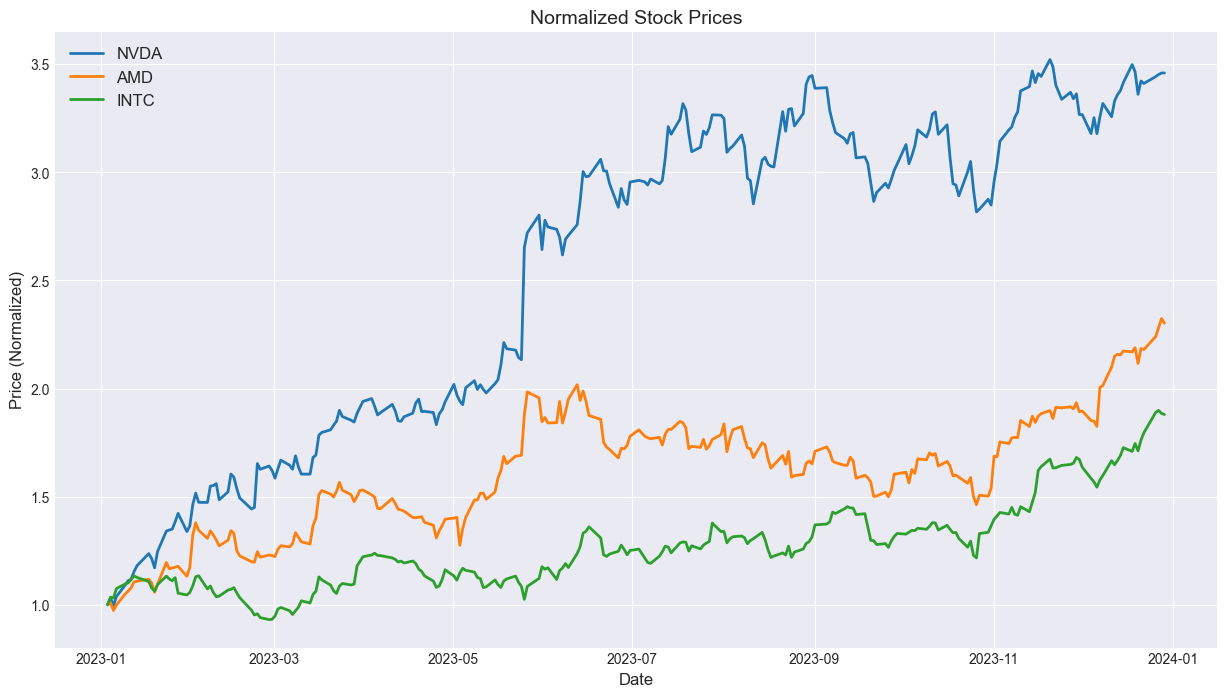

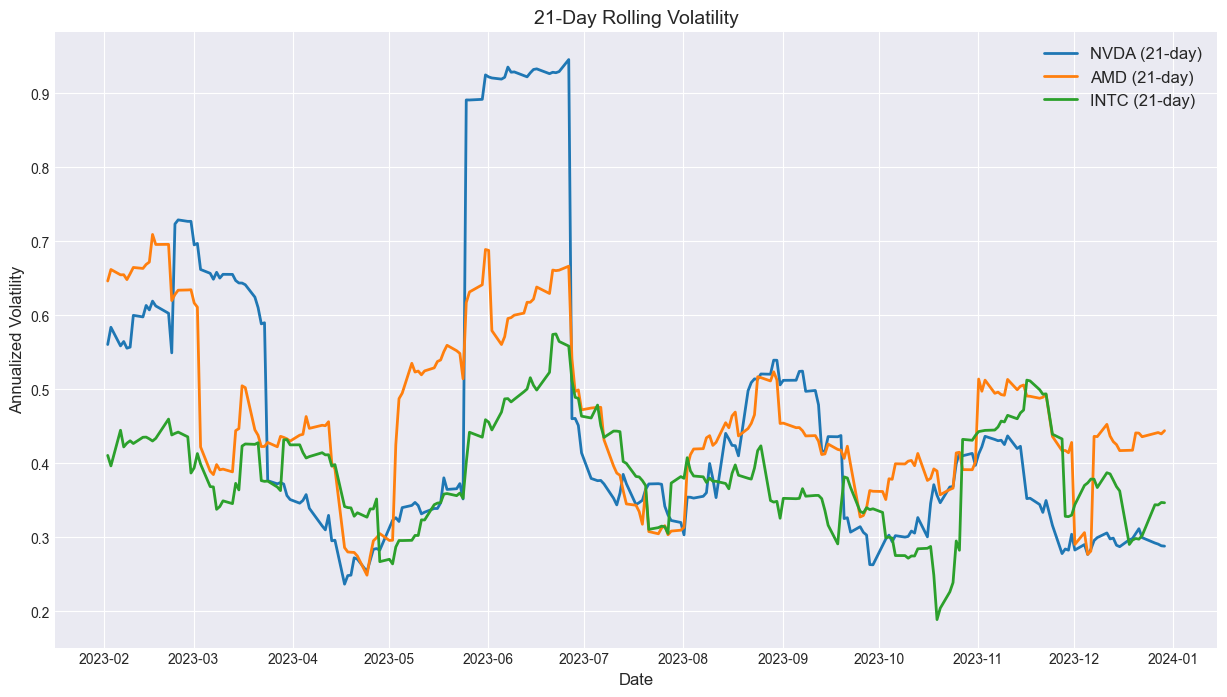

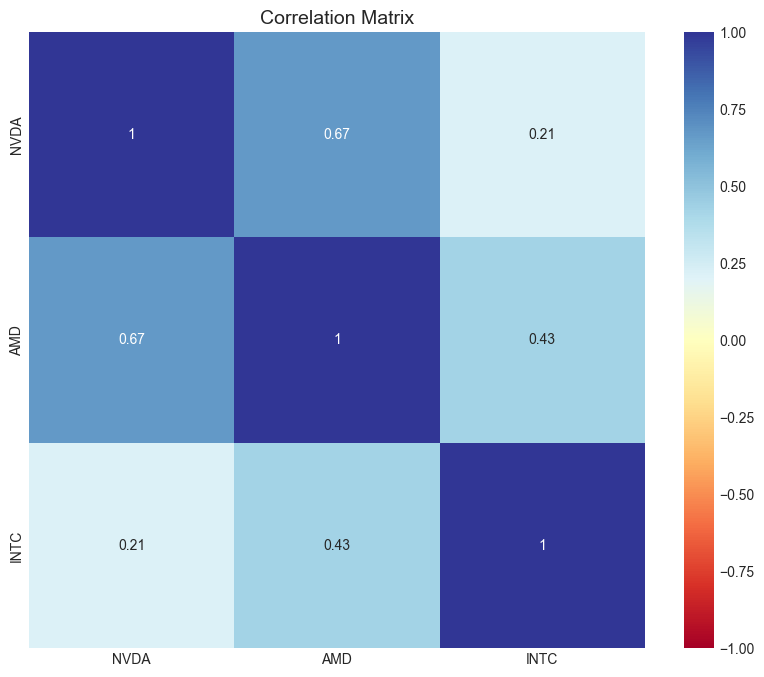


Portfolio Statistics:

Error: unsupported format string passed to Series.__format__


TypeError: unsupported format string passed to Series.__format__

In [1]:
# Imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))  # Add parent directory to path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
from src.data import PortfolioConfig, DataLoader  # Add this import


# Load environment variables
load_dotenv()

# Configuration
test_config = {
    'tickers': ['NVDA', 'AMD', 'INTC'],
    'weights': [0.4, 0.4, 0.2],
    'start_date': '2023-01-01',
    'end_date': '2024-01-01',
    'alpaca_key_id': os.getenv('ALPACA_KEY_ID'),
    'alpaca_secret_key': os.getenv('ALPACA_SECRET_KEY'),
    'paper_trading': True
}

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [15, 10]

try:
    # 1. Initialize Configuration
    print("Configuration:")
    print("-" * 50)
    for key, value in test_config.items():
        if 'secret' not in key.lower():  # Don't print sensitive info
            print(f"{key}: {value}")
    
    # 2. Load Data
    portfolio_config = PortfolioConfig(**test_config)
    loader = DataLoader(portfolio_config)
    market_data = loader.load_stocks()
    
    # 3. Print Data Summary
    print("\nData Summary:")
    print("=" * 50)
    for ticker in test_config['tickers']:
        returns = market_data['returns'][ticker]
        print(f"\n{ticker}:")
        print(f"Annual Return: {returns.mean() * 252:.1%}")
        print(f"Annual Volatility: {returns.std() * np.sqrt(252):.1%}")
    
    print("\nData Loading Successful!")
    print("-" * 50)
    print("\nShape of data:")
    print(f"Close prices: {market_data['close'].shape}")
    print(f"Returns: {market_data['returns'].shape}")
    
    # 4. Visualizations
    # Plot 1: Normalized Prices
    plt.figure(figsize=(15, 8))
    for ticker in test_config['tickers']:
        plt.plot(
            market_data['close'].index,
            market_data['close'][ticker] / market_data['close'][ticker].iloc[0],
            label=ticker,
            linewidth=2
        )
    plt.title('Normalized Stock Prices', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (Normalized)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Plot 2: Rolling Volatility
    plt.figure(figsize=(15, 8))
    window = 21  # 21-day rolling window
    for ticker in test_config['tickers']:
        rolling_vol = market_data['returns'][ticker].rolling(window).std() * np.sqrt(252)
        plt.plot(rolling_vol.index, rolling_vol, label=f'{ticker} ({window}-day)', linewidth=2)
    plt.title(f'{window}-Day Rolling Volatility', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Annualized Volatility', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Plot 3: Correlation Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        market_data['returns'].corr(),
        annot=True,
        cmap='RdYlBu',
        center=0,
        vmin=-1,
        vmax=1,
        square=True
    )
    plt.title('Correlation Matrix', fontsize=14)
    plt.show()

    # 5. Summary Statistics
    stats = loader.get_summary_statistics(market_data)
    print("\nPortfolio Statistics:")
    print("=" * 50)
    print(f"Annual Return: {stats['returns']['mean']:.2%}")
    print(f"Annual Volatility: {stats['returns']['std']:.2%}")
    print(f"Skewness: {stats['returns']['skew']:.2f}")
    print(f"Kurtosis: {stats['returns']['kurt']:.2f}")
    print("\nAverage Daily Volume:")
    for ticker in test_config['tickers']:
        print(f"{ticker}: {stats['daily_volume_avg'][ticker]:,.0f}")

except Exception as e:
    print(f"\nError: {str(e)}")
    raise


In [3]:
# src/data.py
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Union
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import logging
from datetime import datetime, timedelta
import yaml

# Load environment variables
load_dotenv()

@dataclass
class PortfolioConfig:
    """Configuration for portfolio simulation"""
    tickers: List[str]
    weights: List[float]
    start_date: str
    end_date: str
    alpaca_key_id: str = field(default_factory=lambda: os.getenv('ALPACA_KEY_ID', ''))
    alpaca_secret_key: str = field(default_factory=lambda: os.getenv('ALPACA_SECRET_KEY', ''))
    paper_trading: bool = field(default_factory=lambda: os.getenv('PAPER_TRADING', 'true').lower() == 'true')
    
    @classmethod
    def from_yaml(cls, yaml_path: str = 'src/config.yml'):
        """Create configuration from YAML file"""
        with open(yaml_path, 'r') as file:
            config = yaml.safe_load(file)
            return cls(
                tickers=config['portfolio']['tickers'],
                weights=config['portfolio']['weights'],
                start_date=config['portfolio']['dates']['start'],
                end_date=config['portfolio']['dates']['end'],
                paper_trading=config['data_provider']['paper_trading']
            )
    
    def __post_init__(self):
        """Validate configuration after initialization"""
        assert len(self.tickers) == len(self.weights), "Tickers and weights must match"
        assert abs(sum(self.weights) - 1.0) < 1e-6, "Weights must sum to 1"
        assert self.alpaca_key_id, "Alpaca API key ID is required"
        assert self.alpaca_secret_key, "Alpaca secret key is required"

class DataLoader:
    """Loads and processes stock data using Alpaca API"""
    
    def __init__(self, config: PortfolioConfig):
        self.config = config
        self._setup_logging()
        self._setup_api()
    
    def _setup_logging(self):
        """Setup logging configuration"""
        self.logger = logging.getLogger(__name__)
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
            self.logger.setLevel(logging.INFO)
    
    def _setup_api(self):
        """Initialize Alpaca API connection"""
        try:
            self.logger.info("Connecting to Alpaca API...")
            base_url = 'https://data.alpaca.markets'
            
            self.api = tradeapi.REST(
                key_id=self.config.alpaca_key_id,
                secret_key=self.config.alpaca_secret_key,
                base_url=base_url,
                api_version='v2'
            )
            
            # Test connection
            self.api.get_latest_trade('AAPL')
            self.logger.info("Successfully connected to Alpaca Data API")
            
        except Exception as e:
            self.logger.error(f"API setup failed: {str(e)}")
            raise ConnectionError(f"Failed to connect to Alpaca API: {str(e)}")
    
    def load_stocks(self, retries: int = 3) -> Dict:
        """Load and process stock data with retry mechanism"""
        for attempt in range(retries):
            try:
                self.logger.info(f"Loading data for {', '.join(self.config.tickers)}...")
                data = self._fetch_data()
                market_data = self._process_data(data)
                
                if self.validate_data(market_data):
                    self.logger.info("Data validation successful")
                    return market_data
                raise ValueError("Data validation failed")
                
            except Exception as e:
                self.logger.error(f"Attempt {attempt + 1}/{retries} failed: {str(e)}")
                if attempt == retries - 1:
                    raise
    
    def _fetch_data(self) -> Dict[str, pd.DataFrame]:
        """Fetch raw data from Alpaca API"""
        data = {}
        for ticker in self.config.tickers:
            try:
                bars = self.api.get_bars(
                    ticker,
                    tradeapi.TimeFrame.Day,
                    start=pd.Timestamp(self.config.start_date).strftime('%Y-%m-%d'),
                    end=pd.Timestamp(self.config.end_date).strftime('%Y-%m-%d'),
                    adjustment='raw'
                ).df
                
                if bars.empty:
                    raise ValueError(f"No

SyntaxError: EOL while scanning string literal (2517240990.py, line 118)

In [9]:
# Enhanced Risk Analysis Dashboard with Alpaca API
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from hmmlearn import hmm
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [15, 10]

from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.visualization import RiskVisualizer
from src.regime import MarketRegimeDetector, RegimeConfig

# 1. Configure and Load Data
portfolio_config = PortfolioConfig(
    tickers=['NVDA', 'AMD', 'INTC'],  # Removed NASDAQ benchmark as it's not available in Alpaca
    weights=[0.4, 0.4, 0.2],
    start_date='2020-01-01',
    end_date='2024-01-01',
    alpaca_key_id=os.getenv('ALPACA_KEY_ID'),
    alpaca_secret_key=os.getenv('ALPACA_SECRET_KEY'),
    paper_trading=True
)

# Load market data
print(f"Loading data for {', '.join(portfolio_config.tickers)}...")
loader = DataLoader(portfolio_config)
market_data = loader.load_stocks()

# 2. Risk Analysis Configuration
risk_config = RiskConfig(
    confidence_level=0.95,
    max_drawdown_limit=0.40,    # Increased for tech sector volatility
    volatility_target=0.40      # Adjusted for tech sector
)

# Initialize RiskManager with weights
risk_manager = RiskManager(
    config=risk_config,
    risk_free_rate=0.05,
    weights=portfolio_config.weights
)

# Calculate risk metrics
portfolio_returns = market_data['returns']
risk_metrics = risk_manager.calculate_metrics(portfolio_returns)

# 3. Regime Detection
regime_config = RegimeConfig(
    n_regimes=3,
    window_size=21,
    features=['returns', 'volatility']
)

detector = MarketRegimeDetector(regime_config)
portfolio_return_series = portfolio_returns.dot(portfolio_config.weights)
regimes = detector.fit_predict(portfolio_return_series)

# Get regime statistics and transition matrix
regime_stats = detector.get_regime_stats(portfolio_return_series, regimes)
transition_matrix = detector.get_transition_matrix()

# 4. Create Enhanced Visualization Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Cumulative Returns with Regime Overlay
cum_returns = (1 + market_data['returns']).cumprod()
portfolio_cum_returns = cum_returns.dot(portfolio_config.weights)
ax1.plot(cum_returns.index, portfolio_cum_returns, label='Portfolio', color='black', alpha=0.7)

# Add regime overlay
valid_idx = regimes.index.intersection(cum_returns.index)
for regime in detector.regime_labels:
    mask = (regimes[valid_idx] == regime)
    if mask.any():
        color = {'Low Vol': 'green', 'Medium Vol': 'yellow', 'High Vol': 'red'}[regime]
        ax1.fill_between(valid_idx, 0, portfolio_cum_returns[valid_idx], 
                        where=mask, color=color, alpha=0.2)

ax1.set_title('Cumulative Returns with Market Regimes')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True)

# Plot 2: Rolling Volatility
rolling_vol = risk_metrics['rolling_volatility']
rolling_vol.plot(ax=ax2)
ax2.set_title('Rolling Volatility')
ax2.set_ylabel('Annualized Volatility')
ax2.legend(['21-day', '63-day'])
ax2.grid(True)

# Plot 3: Correlation Matrix Heatmap
sns.heatmap(risk_metrics['correlation'],
            annot=True,
            cmap='RdYlGn',
            center=0,
            fmt='.2f',
            ax=ax3)
ax3.set_title('Asset Correlation Matrix')

# Plot 4: Returns Distribution with Regime Analysis
returns = portfolio_return_series
ax4.hist(returns, bins=50, density=True, alpha=0.7, color='gray')
ax4.axvline(risk_metrics['var_95'], color='r', linestyle='--', 
            label=f"VaR (95%): {risk_metrics['var_95']:.2%}")

# Add regime-specific distributions
for regime in detector.regime_labels:
    regime_returns = returns[regimes.index].loc[regimes == regime]
    if len(regime_returns) > 0:
        sns.kdeplot(data=regime_returns, ax=ax4, 
                   label=f"{regime} Distribution")

ax4.set_title('Returns Distribution by Regime')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# 5. Print Enhanced Risk Analysis
print("\nRisk Metrics Summary:")
print("=" * 50)
print(f"Portfolio Volatility: {risk_metrics['portfolio_volatility']:.2%}")
print(f"VaR (95%): {risk_metrics['var_95']:.2%}")
print(f"Expected Shortfall (95%): {risk_metrics['expected_shortfall_95']:.2%}")
print(f"Max Drawdown: {risk_metrics['max_drawdown']:.2%}")
print(f"Sharpe Ratio: {risk_metrics['sharpe_ratio']:.2f}")

# 6. Print Regime Analysis
print("\nHMM Regime Analysis:")
print("=" * 50)
for regime, stats in regime_stats.items():
    print(f"\n{regime} Regime:")
    print(f"Mean Annual Return: {stats['mean_return']:.2%}")
    print(f"Annualized Volatility: {stats['volatility']:.2%}")
    print(f"Sharpe Ratio: {stats['sharpe']:.2f}")
    print(f"% of Time: {stats['frequency']:.1%}")

print("\nRegime Transition Probabilities:")
print("=" * 50)
print(transition_matrix)

# 7. Model Validation
validation_metrics = detector.validate_model(portfolio_return_series, regimes)

print("\nHMM Model Validation:")
print("=" * 50)
print("\nInformation Ratio by Regime:")
for regime, ir in validation_metrics['information_ratio'].items():
    print(f"{regime}: {ir:.2f}")

print(f"\nRegime Persistence: {validation_metrics['regime_persistence']:.2%}")
print(f"Average Regime Duration: {validation_metrics['avg_regime_duration']:.1f} days")
print(f"Log Likelihood: {validation_metrics['log_likelihood']:.2f}")
print(f"AIC: {validation_metrics['aic']:.2f}")
print(f"BIC: {validation_metrics['bic']:.2f}")

# 8. Regime Transition Visualization
plt.figure(figsize=(15, 5))
regime_colors = {'Low Vol': 'green', 'Medium Vol': 'yellow', 'High Vol': 'red'}
for regime in detector.regime_labels:
    mask = (regimes == regime)
    plt.fill_between(regimes.index, 0, 1, where=mask, 
                    color=regime_colors[regime], alpha=0.3, label=regime)

plt.title('Regime Transitions Over Time')
plt.ylabel('Regime')
plt.legend()
plt.grid(True)
plt.show()

# 9. Performance Statistics
print("\nPerformance Statistics:")
print("=" * 50)
total_return = portfolio_cum_returns.iloc[-1] - 1
annualized_return = (1 + total_return) ** (252/len(returns)) - 1
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Risk-Adjusted Return (Sharpe): {risk_metrics['sharpe_ratio']:.2f}")

2024-11-29 21:51:00,677 - src.data - INFO - Connecting to Alpaca API...
2024-11-29 21:51:00,677 - src.data - INFO - Connecting to Alpaca API...
2024-11-29 21:51:00,677 - src.data - INFO - Connecting to Alpaca API...
2024-11-29 21:51:00,677 - src.data - INFO - Connecting to Alpaca API...
2024-11-29 21:51:00,679 - src.data - INFO - Using paper trading: True
2024-11-29 21:51:00,679 - src.data - INFO - Using paper trading: True
2024-11-29 21:51:00,679 - src.data - INFO - Using paper trading: True
2024-11-29 21:51:00,679 - src.data - INFO - Using paper trading: True


Loading data for NVDA, AMD, INTC...


2024-11-29 21:51:01,186 - src.data - INFO - Successfully connected to Alpaca Data API
2024-11-29 21:51:01,186 - src.data - INFO - Successfully connected to Alpaca Data API
2024-11-29 21:51:01,186 - src.data - INFO - Successfully connected to Alpaca Data API
2024-11-29 21:51:01,186 - src.data - INFO - Successfully connected to Alpaca Data API
2024-11-29 21:51:01,187 - src.data - INFO - Loading data for NVDA, AMD, INTC...
2024-11-29 21:51:01,187 - src.data - INFO - Loading data for NVDA, AMD, INTC...
2024-11-29 21:51:01,187 - src.data - INFO - Loading data for NVDA, AMD, INTC...
2024-11-29 21:51:01,187 - src.data - INFO - Loading data for NVDA, AMD, INTC...
2024-11-29 21:51:01,583 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:01,583 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:01,583 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:01,583 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:01,874 

Error: Daily returns outside [-50%, +50%] range


2024-11-29 21:51:02,422 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:02,422 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:02,422 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:02,422 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:02,705 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:02,705 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:02,705 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:02,705 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:03,002 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,002 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,002 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,002 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,006 - src.data - ERROR - Attempt 2/3 failed: Dat

Error: Daily returns outside [-50%, +50%] range


2024-11-29 21:51:03,294 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:03,294 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:03,294 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:03,294 - src.data - INFO - Successfully loaded data for NVDA
2024-11-29 21:51:03,569 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:03,569 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:03,569 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:03,569 - src.data - INFO - Successfully loaded data for AMD
2024-11-29 21:51:03,881 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,881 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,881 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,881 - src.data - INFO - Successfully loaded data for INTC
2024-11-29 21:51:03,886 - src.data - ERROR - Attempt 3/3 failed: Dat

Error: Daily returns outside [-50%, +50%] range


ValueError: Data validation failed

In [7]:
    !pip install hmmlearn

  Using cached scikit_learn-1.5.2-cp39-cp39-macosx_12_0_arm64.whl.metadata (13 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp39-cp39-macosx_12_0_arm64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
